# 🎯 White-Box Uncertainty Quantification

<div style="background-color: rgba(200, 200, 200, 0.1); padding: 20px; border-radius: 8px; margin-bottom: 20px; border: 1px solid rgba(127, 127, 127, 0.2); max-width: 97.5%; overflow-wrap: break-word;">
  <p style="font-size: 16px; line-height: 1.6">
     White-box Uncertainty Quantification (UQ) methods leverage token probabilities to estimate uncertainty. The single-generation white-box UQ methods are significantly faster and cheaper than black-box methods, but require access to the LLM's internal probabilities, meaning they are not necessarily compatible with all LLMs/APIs. This demo provides an illustration of how to use state-of-the-art white-box UQ methods with <code>uqlm</code>. The following single-generation scorers are available:
  </p>
      
*   Minimum token probability ([Manakul et al., 2023](https://arxiv.org/abs/2303.08896))
*   Length-Normalized Sequence Probability ([Malinin & Gales, 2021](https://arxiv.org/pdf/2002.07650))
*   Sequence Probability ([Vashurin et al., 2024](https://arxiv.org/abs/2406.15627))
*   Mean Top-K Token Negentropy ([Scalena et al., 2025](https://arxiv.org/abs/2510.11170); [Manakul et al., 2023](https://arxiv.org/abs/2303.08896))
*   Min Top-K Token Negentropy ([Scalena et al., 2025](https://arxiv.org/abs/2510.11170); [Manakul et al., 2023](https://arxiv.org/abs/2303.08896))
*   Probability Margin ([Farr et al., 2024](https://arxiv.org/abs/2408.08217))
</div>

## 📊 What You'll Do in This Demo

<div style="display: flex; margin-bottom: 15px; align-items: center">
  <div style="background-color: #34a853; color: white; border-radius: 50%; width: 30px; height: 30px; display: flex; justify-content: center; align-items: center; margin-right: 15px; flex-shrink: 0"><strong>1</strong></div>
  <div>
    <p style="margin: 0; font-weight: bold"><a href=#section1>Set up LLM and prompts.</a></p>
    <p style="margin: 0; color: rgba(95, 99, 104, 0.8)">Set up LLM instance and load example data prompts.</p>
  </div>
</div>

<div style="display: flex; margin-bottom: 15px; align-items: center">
  <div style="background-color: #34a853; color: white; border-radius: 50%; width: 30px; height: 30px; display: flex; justify-content: center; align-items: center; margin-right: 15px; flex-shrink: 0"><strong>2</strong></div>
  <div>
    <p style="margin: 0; font-weight: bold"><a href=#section2>Generate LLM Responses and Confidence Scores</a></p>
    <p style="margin: 0; color: rgba(95, 99, 104, 0.8)">Generate and score LLM responses to the example questions using the <code>WhiteBoxUQ()</code> class.</p>
  </div>
</div>

<div style="display: flex; margin-bottom: 25px; align-items: center">
  <div style="background-color: #34a853; color: white; border-radius: 50%; width: 30px; height: 30px; display: flex; justify-content: center; align-items: center; margin-right: 15px; flex-shrink: 0"><strong>3</strong></div>
  <div>
    <p style="margin: 0; font-weight: bold"><a href=#section3>Evaluate Hallucination Detection Performance</a></p>
    <p style="margin: 0; color: rgba(95, 99, 104, 0.8)">Visualize model accuracy at different thresholds of the various white-box UQ confidence scores. Compute precision, recall, and F1-score of hallucination detection.</p>
  </div>
</div>

## ⚖️ Advantages & Limitations

<div style="display: flex; gap: 20px">
  <div style="flex: 1; background-color: rgba(0, 200, 0, 0.1); padding: 15px; border-radius: 8px; border: 1px solid rgba(0, 200, 0, 0.2)">
    <h3 style="color: #2e8b57; margin-top: 0">Pros</h3>
    <ul style="margin-bottom: 0">
      <li><strong>Minimal Latency Impact:</strong> Token probabilities are already returned by the LLM.</li>
      <li><strong>No Added Cost:</strong> Doesn't require additional LLM calls.</li>
    </ul>
  </div>
  
  <div style="flex: 1; background-color: rgba(200, 0, 0, 0.1); padding: 15px; border-radius: 8px; border: 1px solid rgba(200, 0, 0, 0.2)">
    <h3 style="color: #b22222; margin-top: 0">Cons</h3>
    <ul style="margin-bottom: 0">
      <li><strong>Limited Compatibility:</strong> Requires access to token probabilities, not available for all LLMs/APIs.</li>
    </ul>
  </div>
</div>

In [1]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

from uqlm import WhiteBoxUQ
from uqlm.utils import load_example_dataset, math_postprocessor, plot_model_accuracies, Tuner

<a id='section1'></a>
## 1. Set up LLM and Prompts

In this demo, we will illustrate this approach using a set of math questions from the [GSM8K benchmark](https://github.com/openai/grade-school-math). To implement with your use case, simply **replace the example prompts with your data**.  

In [2]:
# Load example dataset (gsm8k)
gsm8k = load_example_dataset("gsm8k", n=200)
gsm8k.head()

Loading dataset - gsm8k...
Processing dataset...
Dataset ready!


,question,answer
0,Natalia sold clips to 48 of her friends in Apr...,72
1,Weng earns $12 an hour for babysitting. Yester...,10
2,Betty is saving money for a new wallet which c...,5
3,"Julie is reading a 120-page book. Yesterday, s...",42
4,James writes a 3-page letter to 2 different fr...,624


In [3]:
# Define prompts
MATH_INSTRUCTION = "When you solve this math problem only return the answer with no additional text.\n"
prompts = [MATH_INSTRUCTION + prompt for prompt in gsm8k.question]

In this example, we use `AzureChatOpenAI` to instantiate our LLM, but any [LangChain Chat Model](https://js.langchain.com/docs/integrations/chat/) may be used. Be sure to **replace with your LLM of choice.**

In [4]:
# import sys
# !{sys.executable} -m pip install langchain-openai

# # User to populate .env file with API credentials
from dotenv import load_dotenv, find_dotenv
from langchain_openai import AzureChatOpenAI

load_dotenv(find_dotenv())
llm = AzureChatOpenAI(
    deployment_name="gpt-4.1-mini",
    openai_api_type="azure",
    openai_api_version="2024-02-15-preview",
    temperature=1,  # User to set temperature
)

<a id='section2'></a>
## 2. Generate responses and confidence scores

### `WhiteBoxUQ()` - Generate LLM responses and compute token-probability-based confidence scores for each response.

![Sample Image](https://raw.githubusercontent.com/cvs-health/uqlm/develop/assets/images/white_box_graphic.png)

#### 📋 Class Attributes

<table style="border-collapse: collapse; width: 100%; border: 1px solid rgba(127, 127, 127, 0.2);">
  <tr>
    <th style="background-color: rgba(200, 200, 200, 0.2); width: 20%; padding: 8px; text-align: left; border: 1px solid rgba(127, 127, 127, 0.2);">Parameter</th>
    <th style="background-color: rgba(200, 200, 200, 0.2); width: 25%; padding: 8px; text-align: left; border: 1px solid rgba(127, 127, 127, 0.2);">Type & Default</th>
    <th style="background-color: rgba(200, 200, 200, 0.2); width: 55%; padding: 8px; text-align: left; border: 1px solid rgba(127, 127, 127, 0.2);">Description</th>
  </tr>
  <tr>
    <td style="font-weight: bold; padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">llm</td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">BaseChatModel<br><code>default=None</code></td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">A langchain llm `BaseChatModel`. User is responsible for specifying temperature and other relevant parameters to the constructor of their `llm` object.</td>
  </tr>
  <tr>
    <td style="font-weight: bold; padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">scorers</td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">List[str]<br><code>default=None</code></td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">Specifies which white-box (token-probability-based) scorers to include. Must be subset of {"normalized_probability", "min_probability", "sequence_probability", "max_token_negentropy", "mean_token_negentropy", "probability_margin", "monte_carlo_negentropy", "consistency_and_confidence"}. If None, defaults to ["normalized_probability", "min_probability"].</td>
  </tr>    
  <tr>
    <td style="font-weight: bold; padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">system_prompt</td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">str or None<br><code>default="You are a helpful assistant."</code></td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">Optional argument for user to provide custom system prompt for the LLM.</td>
  </tr>
  <tr>
    <td style="font-weight: bold; padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">max_calls_per_min</td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">int<br><code>default=None</code></td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">Specifies how many API calls to make per minute to avoid rate limit errors. By default, no limit is specified.</td>
  </tr>
</table>

#### 🔍 Parameter Groups

<div style="display: flex; gap: 20px; margin-bottom: 20px">
  <div style="flex: 1; padding: 10px; background-color: rgba(0, 100, 200, 0.1); border-radius: 5px; border: 1px solid rgba(0, 100, 200, 0.2);">
    <p style="font-weight: bold">🧠 Model-Specific</p>
    <ul>
      <li><code>llm</code></li>
      <li><code>system_prompt</code></li>
    </ul>
  </div>
  <div style="flex: 1; padding: 10px; background-color: rgba(0, 200, 0, 0.1); border-radius: 5px; border: 1px solid rgba(0, 200, 0, 0.2);">
    <p style="font-weight: bold">📊 Confidence Scores</p>
    <ul>
      <li><code>scorers</code></li>
    </ul>
  </div>
  <div style="flex: 1; padding: 10px; background-color: rgba(200, 0, 200, 0.1); border-radius: 5px; border: 1px solid rgba(200, 0, 200, 0.2);">
    <p style="font-weight: bold">⚡ Performance</p>
    <ul>
      <li><code>max_calls_per_min</code></li>
    </ul>
  </div>
</div>

In [5]:
scorers = [
    # these two scorers require only one logprob per token
    "min_probability",
    "normalized_probability",
    # LLM must support access to Top K logprobs for the below scorers (in Beta). Comment these out if your LLM does not support.
    "mean_token_negentropy",
    "min_token_negentropy",
    "probability_margin",
]
wbuq = WhiteBoxUQ(llm=llm, scorers=scorers)

/home/jupyter/uqlm/uqlm/scorers/white_box.py:177: UQLMBetaWarning: Scoring with top_logprobs is in beta. Please use it with caution as it may change in future releases.
  beta_warning("Scoring with top_logprobs is in beta. Please use it with caution as it may change in future releases.")


### 🔄 Class Methods

<table style="border-collapse: collapse; width: 100%; border: 1px solid rgba(127, 127, 127, 0.2);">
  <tr>
    <th style="background-color: rgba(200, 200, 200, 0.2); width: 25%; padding: 8px; text-align: left; border: 1px solid rgba(127, 127, 127, 0.2);">Method</th>
    <th style="background-color: rgba(200, 200, 200, 0.2); width: 75%; padding: 8px; text-align: left; border: 1px solid rgba(127, 127, 127, 0.2);">Description & Parameters</th>
  </tr>
  <tr>
    <td style="font-weight: bold; vertical-align: top; padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">WhiteBoxUQ.generate_and_score</td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">
      <p>Generate LLM responses and compute confidence scores for the provided prompts.</p>
      <p><strong>Parameters:</strong></p>
      <ul>
        <li><code>prompts</code> - (<strong>List[str] or List[List[BaseMessage]]</strong>) A list of input prompts for the model.</li>
        <li><code>show_progress_bars</code> - (<strong>bool, default=True</strong>) If True, displays a progress bar while generating and scoring responses.</li>  
      </ul>
      <p><strong>Returns:</strong> <code>UQResult</code> containing data (prompts, responses, log probabilities, and confidence scores) and metadata</p>
      <div style="background-color: rgba(0, 200, 0, 0.1); padding: 8px; border-radius: 3px; margin-top: 10px; border: 1px solid rgba(0, 200, 0, 0.2); margin-right: 5px; box-sizing: border-box; width: 100%;">
        <strong>💡 Best For:</strong> Complete end-to-end uncertainty quantification when starting with prompts.
      </div>
    </td>
  </tr>
</table>

In [6]:
results = await wbuq.generate_and_score(prompts=prompts)

Output()

In [7]:
result_df = results.to_df()
result_df.head()

,prompt,response,logprob,normalized_probability,min_probability,probability_margin,min_token_negentropy,mean_token_negentropy
0,When you solve this math problem only return t...,72,"[{'token': '72', 'bytes': [55, 50], 'logprob':...",1.000000,1.000000,1.000000,1.000000,1.000000
1,When you solve this math problem only return t...,$10,"[{'token': '$', 'bytes': [36], 'logprob': -0.0...",0.961322,0.924141,0.924141,0.900832,0.950416
2,When you solve this math problem only return t...,40,"[{'token': '40', 'bytes': [52, 48], 'logprob':...",0.043972,0.043972,0.615345,0.557943,0.557943
3,When you solve this math problem only return t...,33,"[{'token': '33', 'bytes': [51, 51], 'logprob':...",0.271837,0.271837,0.060130,0.229930,0.229930
4,When you solve this math problem only return t...,624,"[{'token': '624', 'bytes': [54, 50, 52], 'logp...",0.893293,0.893293,0.786605,0.874562,0.874562


<a id='section3'></a>
## 3. Evaluate Hallucination Detection Performance

To evaluate hallucination detection performance, we 'grade' the responses against an answer key. Note the `math_postprocessor` is specific to our use case (math questions). **If you are using your own prompts/questions, update the grading method accordingly**.

In [8]:
# Populate correct answers
result_df["answer"] = gsm8k.answer

# Grade responses against correct answers
result_df["response_correct"] = [math_postprocessor(r) == a for r, a in zip(result_df["response"], gsm8k["answer"])]
result_df.head(5)

,prompt,response,logprob,normalized_probability,min_probability,probability_margin,min_token_negentropy,mean_token_negentropy,answer,response_correct
0,When you solve this math problem only return t...,72,"[{'token': '72', 'bytes': [55, 50], 'logprob':...",1.000000,1.000000,1.000000,1.000000,1.000000,72,True
1,When you solve this math problem only return t...,$10,"[{'token': '$', 'bytes': [36], 'logprob': -0.0...",0.961322,0.924141,0.924141,0.900832,0.950416,10,True
2,When you solve this math problem only return t...,40,"[{'token': '40', 'bytes': [52, 48], 'logprob':...",0.043972,0.043972,0.615345,0.557943,0.557943,5,False
3,When you solve this math problem only return t...,33,"[{'token': '33', 'bytes': [51, 51], 'logprob':...",0.271837,0.271837,0.060130,0.229930,0.229930,42,False
4,When you solve this math problem only return t...,624,"[{'token': '624', 'bytes': [54, 50, 52], 'logp...",0.893293,0.893293,0.786605,0.874562,0.874562,624,True


In [9]:
print(f"""Baseline LLM accuracy: {np.mean(result_df["response_correct"])}""")

Baseline LLM accuracy: 0.47


#### 3.1 Filtered LLM Accuracy Evaluation

Here, we explore ‘filtered accuracy’ as a metric for evaluating the performance of our confidence scores. Filtered accuracy measures the change in LLM performance when responses with confidence scores below a specified threshold are excluded. By adjusting the confidence score threshold, we can observe how the accuracy of the LLM improves as less certain responses are filtered out.

We will plot the filtered accuracy across various confidence score thresholds to visualize the relationship between confidence and LLM accuracy. This analysis helps in understanding the trade-off between response coverage (measured by sample size below) and LLM accuracy, providing insights into the reliability of the LLM’s outputs. We conduct this analysis separately for each of our scorers. 

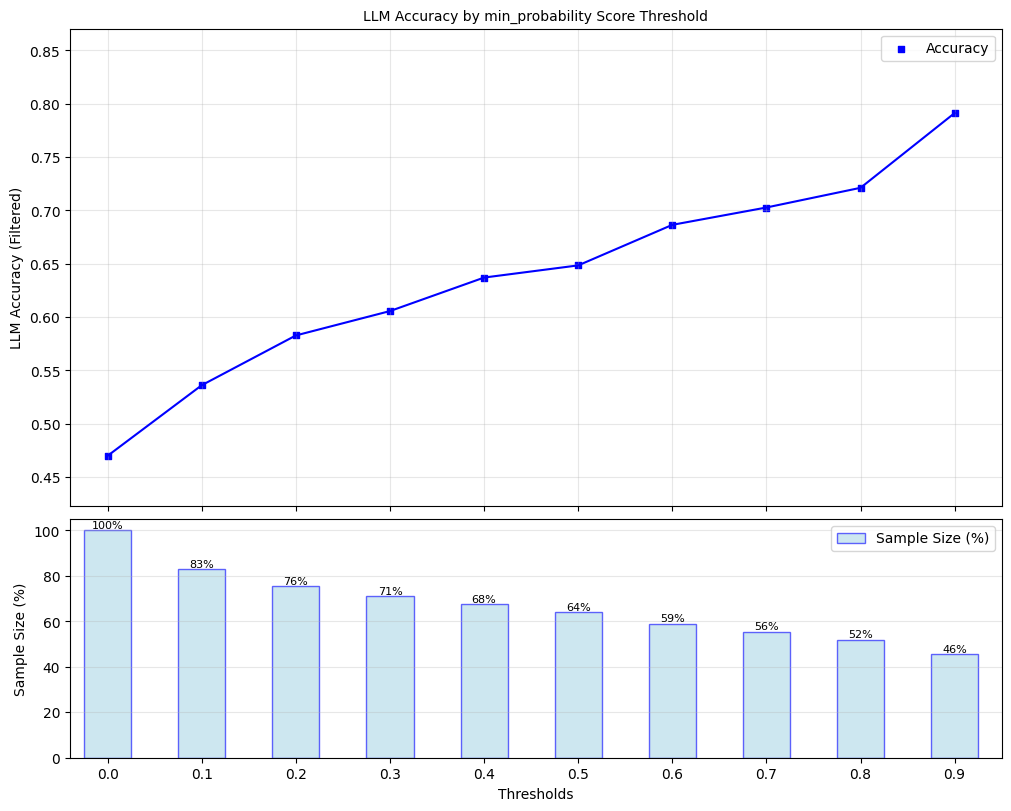

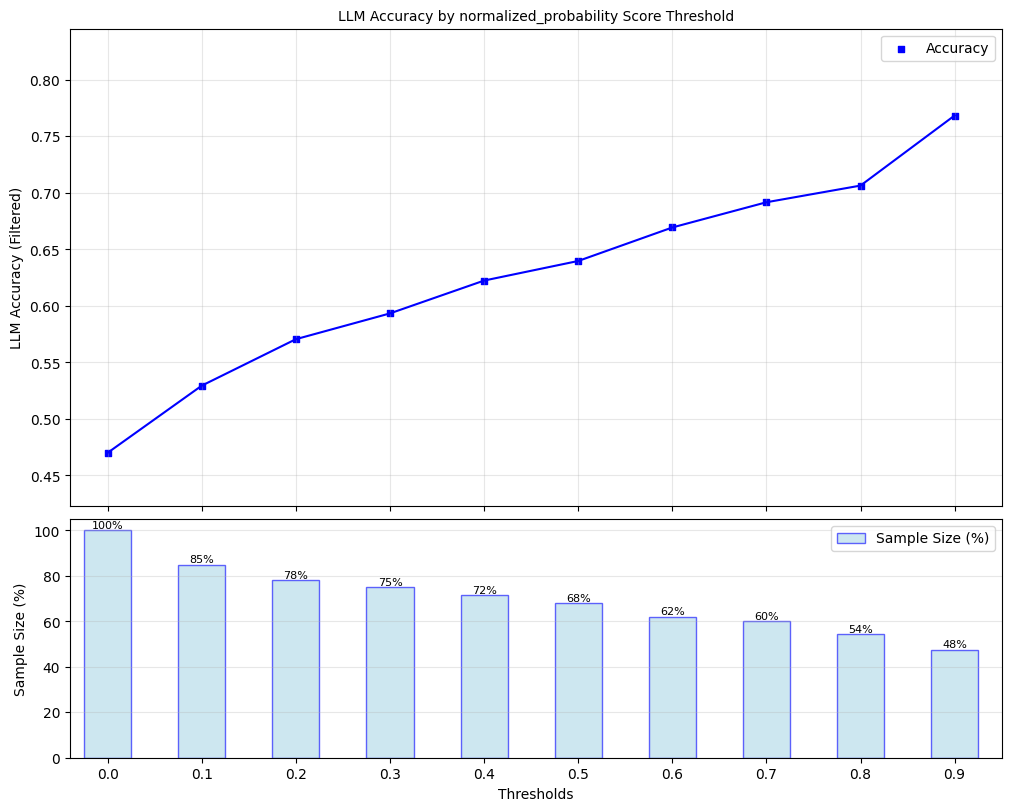

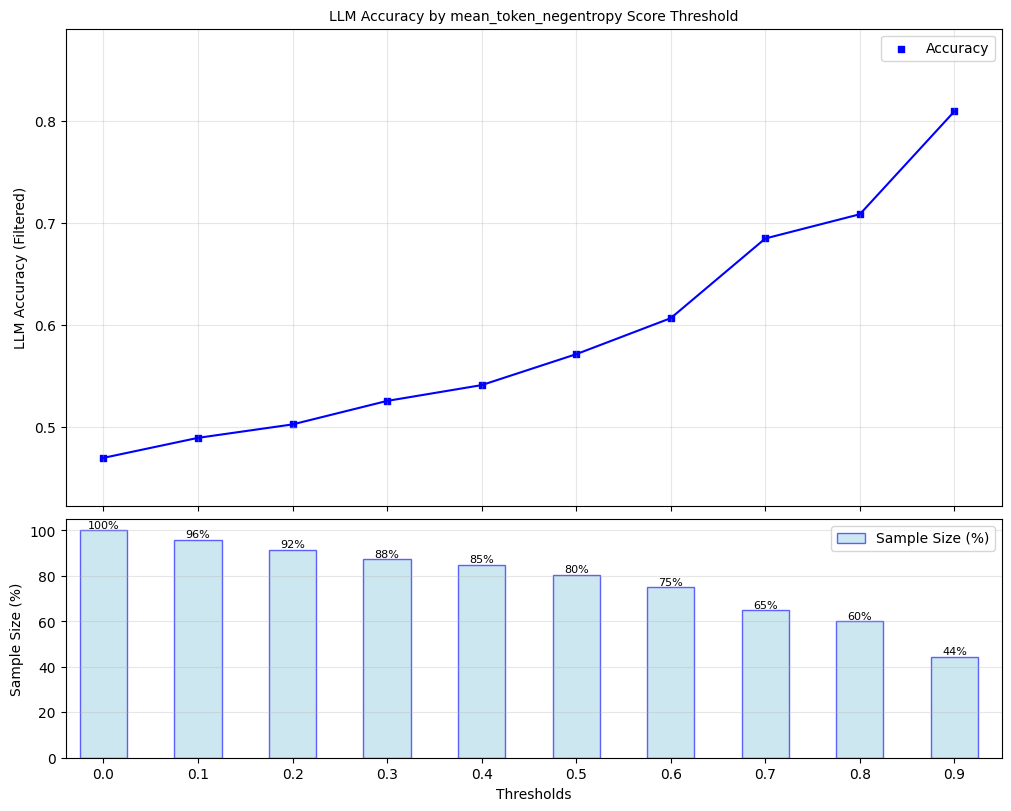

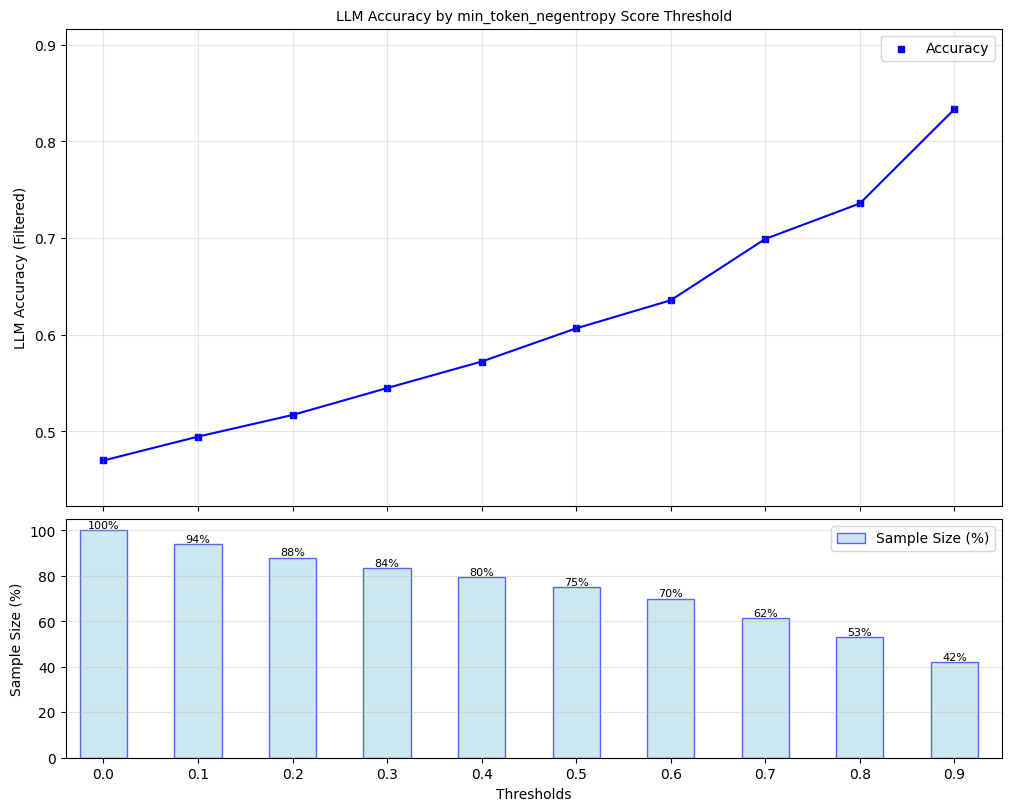

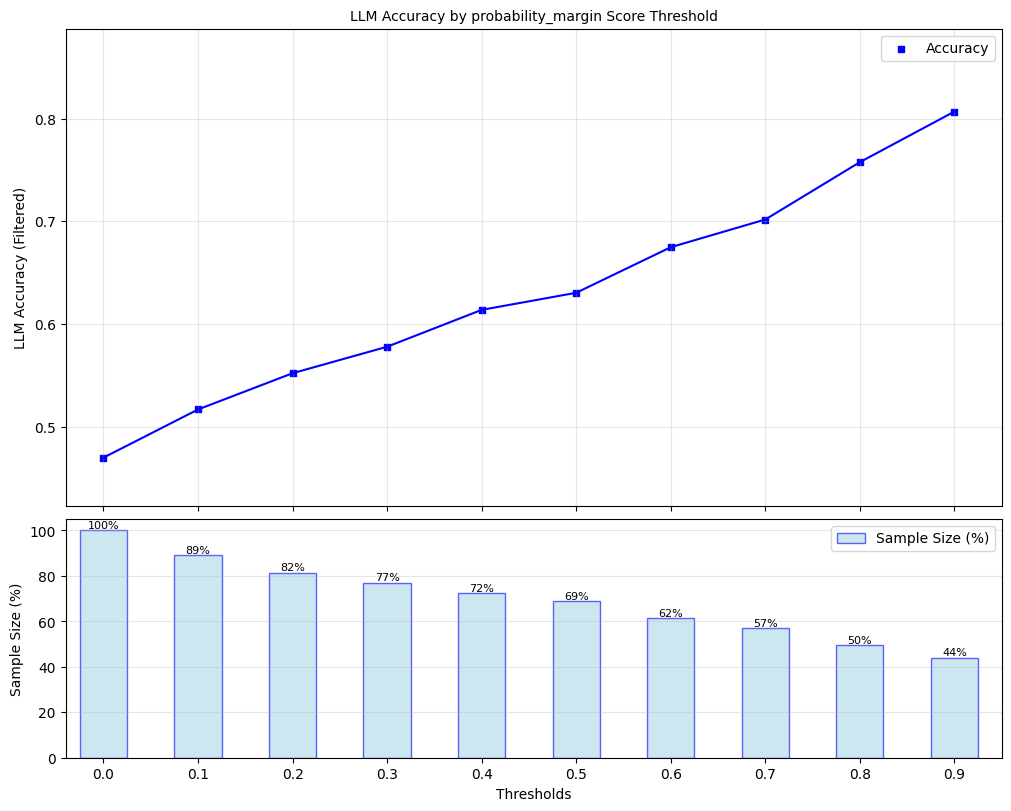

In [10]:
for scorer in scorers:
    plot_model_accuracies(scores=result_df[scorer], correct_indicators=result_df.response_correct, title=f"LLM Accuracy by {scorer} Score Threshold", display_percentage=True)

#### 3.2 Precision, Recall, F1-Score of Hallucination Detection

Lastly, we compute the optimal threshold for binarizing confidence scores, using F1-score as the objective. Using this threshold, we compute precision, recall, and F1-score for black box scorer predictions of whether responses are correct.

In [11]:
# instantiate UQLM tuner object for threshold selection
split = len(result_df) // 2
t = Tuner()

correct_indicators = (result_df.response_correct) * 1  # Whether responses is actually correct
metric_values = {"Precision": [], "Recall": [], "F1-score": []}
optimal_thresholds = []
for confidence_score in wbuq.scorers:
    # tune threshold on first half
    y_scores = result_df[confidence_score]
    y_scores_tune = y_scores[0:split]
    y_true_tune = correct_indicators[0:split]
    best_threshold = t.tune_threshold(y_scores=y_scores_tune, correct_indicators=y_true_tune, thresh_objective="fbeta_score")

    y_pred = [(s > best_threshold) * 1 for s in y_scores]  # predicts whether response is correct based on confidence score
    optimal_thresholds.append(best_threshold)

    # evaluate on last half
    y_true_eval = correct_indicators[split:]
    y_pred_eval = y_pred[split:]
    metric_values["Precision"].append(precision_score(y_true=y_true_eval, y_pred=y_pred_eval))
    metric_values["Recall"].append(recall_score(y_true=y_true_eval, y_pred=y_pred_eval))
    metric_values["F1-score"].append(f1_score(y_true=y_true_eval, y_pred=y_pred_eval))

# print results
header = f"{'Metrics':<25}" + "".join([f"{scorer_name:<25}" for scorer_name in wbuq.scorers])
print("=" * len(header) + "\n" + header + "\n" + "-" * len(header))
for metric in metric_values.keys():
    print(f"{metric:<25}" + "".join([f"{round(x_, 3):<25}" for x_ in metric_values[metric]]))
print("-" * len(header))
print(f"{'F-1 optimal threshold':<25}" + "".join([f"{round(x_, 3):<25}" for x_ in optimal_thresholds]))
print("=" * len(header))

Metrics                  min_probability          normalized_probability   mean_token_negentropy    min_token_negentropy     probability_margin       
------------------------------------------------------------------------------------------------------------------------------------------------------
Precision                0.776                    0.689                    0.721                    0.71                     0.765                    
Recall                   0.76                     0.84                     0.88                     0.88                     0.78                     
F1-score                 0.768                    0.757                    0.793                    0.786                    0.772                    
------------------------------------------------------------------------------------------------------------------------------------------------------
F-1 optimal threshold    0.9                      0.68                     0.75               

<a id='section4'></a>
## 4. Scorer Definitions
White-box UQ scorers leverage token probabilities of the LLM's generated response to quantify uncertainty. All scorers have outputs ranging from 0 to 1, with higher values indicating higher confidence. We define several white-box UQ scorers below.

The first three scorers we consider require accessing only a single logprob per token in the generated response. Let the tokenization LLM response $y_i$ be denoted as $\{t_1,...,t_{L_i}\}$, where $L_i$ denotes the number of tokens the response.  
### Sequence Probability (`sequence_probability`)
Sequence probability is the joint probability of all tokens:

\begin{equation}
    SP(y_i) = \prod_{t \in y_i}  p_t,
\end{equation}
where $p_t$ denotes the token probability for token $t$. For more on this scorer, refer to [Vashurin et al., 2024](https://arxiv.org/abs/2406.15627).

### Length-Normalized Sequence Probability (`normalized_probability`)
Length-normalized token (sequence) probability (LNTP) computes a length-normalized analog of joint token probability:

\begin{equation}
    LNTP(y_i) = \prod_{t \in y_i}  p_t^{\frac{1}{L_i}}.
\end{equation}
Note that this score is equivalent to the geometric mean of token probabilities for response $y_i$. For more on this scorer, refer to [Malinin & Gales, 2021](https://arxiv.org/pdf/2002.07650).

### Minimum Token Probability (`min_probability`)
Minimum token probability (MTP) uses the minimum among token probabilities for a given responses as a confidence score:

\begin{equation}
    MTP(y_i) = \min_{t \in y_i}  p_t,
\end{equation}
where $t$ and $p_t$ follow the same definitions as above. For more on this scorer, refer to [Manakul et al., 2023](https://arxiv.org/abs/2303.08896).

The next three scorers we consider require accessing the top-K logprobs per token in the generated response. Let the top-K token probabilities for token $t_j$ be denoted as $\{t_{jk}\}_{k=1}^K$.

### Probability Margin (`probability_margin`)
Probability margin is the average difference between the top two token probabilities for each token:

\begin{equation}
    PM(y_i) = \frac{1}{L_i}\sum_{j = 1}^{L_i} (p_{t_{j1}} - p_{t_{j2}}),
\end{equation}
For more on this scorer, refer to [Farr et al., 2024](https://arxiv.org/abs/2408.08217).

### Average Token Negentropy (`mean_token_negentropy`)
Average token negentropy (ATN) computes the entropy of each token using the top-K logprobs, transforms them to normalized negentropy scores (bound in [0,1]; higher values indicate higher confidence), and averages these negentropy scores to obtain a confidence score for each response. We first define Top-K token entropy for token $j$ as follows:

\begin{equation}
    TE@K(t_j) = -\sum_{k=1}^{K} p_{t_{jk}} \log p_{t_{jk}},
\end{equation}

Following [Bouchard and Chauhan, 2025](https://arxiv.org/abs/2504.19254), the token negentropy (TN) transformation is obtained as follows:
\begin{equation}
    TN@K(t_j) = 1 + \frac{TE@K(y_i)}{\log K}.
\end{equation}

Finally, ATN is the simple average of token negentropies across tokens in the response.
\begin{equation}
    ATN(y_i) = \frac{1}{L_i}\sum_{j = 1}^{L_i} TN@K(t_j).
\end{equation}
This scorer is adapted from [Scalena et al., 2025](https://arxiv.org/abs/2510.11170) and [Manakul et al., 2023](https://arxiv.org/abs/2303.08896).

### Minimum Token Negentropy (`min_token_negentropy`)
Minimum token negentropy (MTN) uses the minimum among token-level negentropies for a given responses as a confidence score:

\begin{equation}
    MTN(y_i) = \min_{j \in \{1,...,L_i\}} TN@K(t_j).
\end{equation}
This scorer is adapted from [Scalena et al., 2025](https://arxiv.org/abs/2510.11170) and [Manakul et al., 2023](https://arxiv.org/abs/2303.08896).


© 2025 CVS Health and/or one of its affiliates. All rights reserved.